In [1]:
import utils.constants as constants
import preparation.database as database
import preparation.labeling as labeling

<AxesSubplot:>

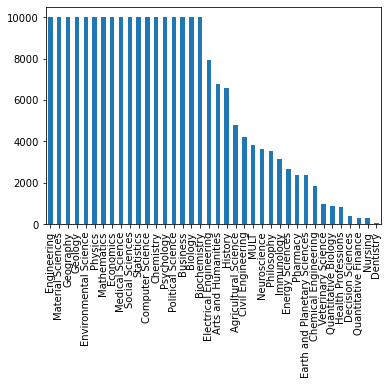

In [2]:
data = database.extract_stratified_sample(n_per_subject=10_000)
data["SUBJECT"].value_counts().plot(kind = "bar")

In [ ]:
model = labeling.train_singlelabel(data)

In [ ]:
model = labeling.train_singlelabel_dictionary(data)

In [ ]:
model = labeling.train_singlelabel_embeddings(data)

In [ ]:
model = labeling.train_singlelabel_tfidf(data)

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

import utils.constants as constants
from utils.text_processing import text2vec, load_embeddings

In [9]:
# AdaBoost Classifier

data = pd.read_parquet("embedded_sample.parquet")
data = data.sample(frac=1)
data = data.reset_index(drop=True)

embeddings, dim = load_embeddings(constants.STARSPACE_EMBEDDINGS)
data["EMBEDDING"] = data["ABSTRACT"].apply(lambda text: text2vec(text, embeddings, dim = dim))

train, val = train_test_split(
    data,
    train_size=0.95,
    random_state=0
)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

value_counts = data["SUBJECT"].value_counts()
frequencies = value_counts / value_counts.sum()

train_x = np.stack(train["EMBEDDING"].values)
train_y = train["SUBJECT"]

param_grid = {
"learning_rate": [0.125, 0.25, 0.75, 1],
"n_estimators": range(50, 300, 100)
}

print("Starting training!")

model = AdaBoostClassifier(random_state=0)
grid_cv = GridSearchCV(model, param_grid, cv=3, verbose=4, scoring="accuracy", n_jobs=4)
grid_cv.fit(train_x, train_y)

print("Best accuracy: {}".format(grid_cv.best_score_))
print("Best hyperparameters: \n{}".format(grid_cv.best_params_))

Starting training!
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END learning_rate=0.25, n_estimators=100;, score=0.344 total time=11.3min
[CV 1/5] END learning_rate=0.25, n_estimators=100;, score=0.337 total time=11.3min
[CV 2/5] END learning_rate=0.25, n_estimators=100;, score=0.343 total time=11.3min
[CV 4/5] END learning_rate=0.25, n_estimators=100;, score=0.336 total time=11.3min
[CV 5/5] END learning_rate=0.25, n_estimators=100;, score=0.343 total time=11.0min
[CV 2/5] END learning_rate=0.25, n_estimators=200;, score=0.342 total time=21.8min
[CV 1/5] END learning_rate=0.25, n_estimators=200;, score=0.342 total time=21.8min
[CV 3/5] END learning_rate=0.25, n_estimators=200;, score=0.350 total time=21.9min
[CV 4/5] END learning_rate=0.25, n_estimators=200;, score=0.339 total time=21.7min
[CV 1/5] END learning_rate=0.75, n_estimators=100;, score=0.167 total time=10.9min
[CV 2/5] END learning_rate=0.75, n_estimators=100;, score=0.176 total time=10.9min
[CV 3/5]

In [ ]:
# Support Vector Machine

data = pd.read_parquet("embedded_sample.parquet")
data = data.sample(frac=1)
data = data.reset_index(drop=True)

embeddings, dim = load_embeddings(constants.STARSPACE_EMBEDDINGS)
data["EMBEDDING"] = data["ABSTRACT"].apply(lambda text: text2vec(text, embeddings, dim = dim))

train, val = train_test_split(
    data,
    train_size=0.8,
    random_state=0
)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

value_counts = data["SUBJECT"].value_counts()
frequencies = value_counts / value_counts.sum()

train_x = np.stack(train["EMBEDDING"].values)
train_y = train["SUBJECT"]

print("Starting training!")

param_grid = {
    "C": [0.125, 0.25, 0.5, 1]
}

model = LinearSVC(random_state=0, class_weight="balanced")
grid_cv = GridSearchCV(model, param_grid, cv=5, verbose=4, scoring="accuracy")
grid_cv.fit(train_x, train_y)

print("Best accuracy: {}".format(grid_cv.best_score_))
print("Best hyperparameters: \n{}".format(grid_cv.best_params_))

In [12]:
# Random Forest Classifier

data = pd.read_parquet("embedded_sample.parquet")
data = data.sample(frac=1)
data = data.reset_index(drop=True)

embeddings, dim = load_embeddings(constants.STARSPACE_EMBEDDINGS)
data["EMBEDDING"] = data["ABSTRACT"].apply(lambda text: text2vec(text, embeddings, dim = dim))

train, val = train_test_split(
    data,
    train_size=0.8,
    random_state=0
)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

value_counts = data["SUBJECT"].value_counts()
frequencies = value_counts / value_counts.sum()

train_x = np.stack(train["EMBEDDING"].values)
train_y = train["SUBJECT"]

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [500, 750, 1000], 
    "criterion": ["gini"],
}

classifier = RandomForestClassifier()
grid_cv = GridSearchCV(classifier, param_grid, cv=5, scoring = "f1_weighted", verbose = 4, n_jobs=4)
grid_cv.fit(train_x, train_y)

print("Best accuracy: {}".format(grid_cv.best_score_))
print("Best hyperparameters: \n{}".format(grid_cv.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 4/5] END criterion=gini, max_depth=500, n_estimators=100;, score=0.370 total time= 2.8min
[CV 1/5] END criterion=gini, max_depth=500, n_estimators=100;, score=0.368 total time= 2.9min
[CV 2/5] END criterion=gini, max_depth=500, n_estimators=100;, score=0.375 total time= 2.9min
[CV 3/5] END criterion=gini, max_depth=500, n_estimators=100;, score=0.372 total time= 2.9min
[CV 5/5] END criterion=gini, max_depth=500, n_estimators=100;, score=0.368 total time= 2.8min
[CV 1/5] END criterion=gini, max_depth=500, n_estimators=200;, score=0.381 total time= 5.7min
[CV 3/5] END criterion=gini, max_depth=500, n_estimators=200;, score=0.386 total time= 5.7min
[CV 2/5] END criterion=gini, max_depth=500, n_estimators=200;, score=0.385 total time= 5.7min
[CV 4/5] END criterion=gini, max_depth=500, n_estimators=200;, score=0.385 total time= 5.6min
[CV 5/5] END criterion=gini, max_depth=500, n_estimators=200;, score=0.380 total time= 5.5min
